<a href="https://colab.research.google.com/github/aderobaki/Data-Science-Projs/blob/workflows/Sales_Data_prediction_using_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **File descriptions**
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# To tune model, get different metric scores, and split data
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


from sklearn.model_selection import GridSearchCV
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df_train= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sales Data Prediction/sales_train.csv")
df_test= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sales Data Prediction/test.csv")

In [4]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
df_train.sample(10, random_state=42)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2472142,06.02.2015,25,31,11208,699.0,1.0
1044690,21.11.2013,10,31,19525,149.0,1.0
2367559,03.01.2015,24,42,16169,299.0,1.0
1793501,18.07.2014,18,42,2737,199.0,1.0
1585639,13.04.2014,15,2,15229,1199.0,1.0
1229976,27.12.2013,11,57,2269,799.0,1.0
183439,08.02.2013,1,31,18151,149.0,1.0
2343443,08.01.2015,24,27,6184,699.0,1.0
485890,09.05.2013,4,54,4908,899.0,1.0
431646,27.04.2013,3,42,2447,1999.0,1.0


In [8]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [9]:
df_train.shape

(2935849, 6)

### Data Preprocessing

In [10]:
#convert negative values in item_price
df_train['item_price'] = abs(df_train['item_price'])
df_train['item_cnt_day'] = abs(df_train['item_cnt_day'])

In [11]:
#change date from obj to datetime

df_train['date'] = df_train['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [12]:
df_train['month'] = df_train['date'].dt.to_period('M').astype(str)


In [13]:
df_train['month'] = pd.to_datetime(df_train['month'])
df_train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
month             datetime64[ns]
dtype: object

In [14]:
df_train["sale_revenue"]=df_train["item_cnt_day"] * df_train["item_price"] 

In [15]:
df_train.sample(10, random_state=42)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,sale_revenue
2472142,2015-02-06,25,31,11208,699.0,1.0,2015-02-01,699.0
1044690,2013-11-21,10,31,19525,149.0,1.0,2013-11-01,149.0
2367559,2015-01-03,24,42,16169,299.0,1.0,2015-01-01,299.0
1793501,2014-07-18,18,42,2737,199.0,1.0,2014-07-01,199.0
1585639,2014-04-13,15,2,15229,1199.0,1.0,2014-04-01,1199.0
1229976,2013-12-27,11,57,2269,799.0,1.0,2013-12-01,799.0
183439,2013-02-08,1,31,18151,149.0,1.0,2013-02-01,149.0
2343443,2015-01-08,24,27,6184,699.0,1.0,2015-01-01,699.0
485890,2013-05-09,4,54,4908,899.0,1.0,2013-05-01,899.0
431646,2013-04-27,3,42,2447,1999.0,1.0,2013-04-01,1999.0


In [16]:
df_train.shape

(2935849, 8)

### **Exploratory Data Analsyis**

In [17]:
# General statistics
def stats(df,x):
    print(f"Variable: {x}")
    print(f"Type of variable: {df[x].dtype}")
    print(f"Total observations: {df[x].shape[0]}")
    detect_null_val = df[x].isnull().values.any()
    if detect_null_val:
        print(f"Missing values: {df[x].isnull().sum()} ({(df[x].isnull().sum() / df[x].isnull().shape[0] *100).round(2)}%)")
    else:
        print(f"Missing values? {df[x].isnull().values.any()}")
    print(f"Unique values: {df[x].nunique()}")
    if df[x].dtype != "O":
        print(f"Min: {int(df[x].min())}")
        print(f"25%: {int(df[x].quantile(q=[.25]).iloc[-1])}")
        print(f"Median: {int(df[x].median())}")
        print(f"75%: {int(df[x].quantile(q=[.75]).iloc[-1])}")
        print(f"Max: {int(df[x].max())}")
        print(f"Mean: {df[x].mean()}")
        print(f"Std dev: {df[x].std()}")
        print(f"Variance: {df[x].var()}")
        print(f"Skewness: {scipy.stats.skew(df[x])}")
        print(f"Kurtosis: {scipy.stats.kurtosis(df[x])}")
        print("")
        
        # Percentiles 1%, 5%, 95% and 99%
        print("Percentiles 1%, 5%, 95%, 99%")
        display(df[x].quantile(q=[.01, .05, .95, .99]))
        print("")
    else:
        print(f"List of unique values: {df[x].unique()}")

# Histogram
def hist(x):
    plt.hist(df[x], bins=25)
    plt.title(x, fontsize=10, loc="right")
    plt.xlabel('Relative frequency')
    plt.ylabel('Absolute frequency')
    plt.show()


In [18]:
stats(df_train,"item_cnt_day")

Variable: item_cnt_day
Type of variable: float64
Total observations: 2935849
Missing values? False
Unique values: 189
Min: 1
25%: 1
Median: 1
75%: 1
Max: 2169
Mean: 1.2477780703299113
Std dev: 2.6163906491029
Variance: 6.8455000287130945
Skewness: 273.59462104983817
Kurtosis: 178139.66271572706

Percentiles 1%, 5%, 95%, 99%


0.01    1.0
0.05    1.0
0.95    2.0
0.99    5.0
Name: item_cnt_day, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


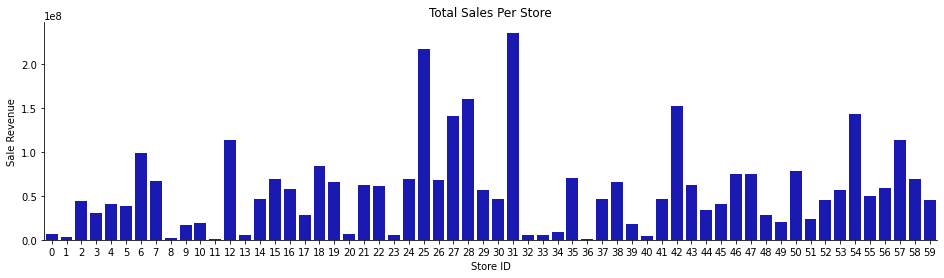

In [19]:
 #lets see the revenue per shop
 store = df_train.groupby('shop_id')['sale_revenue'].sum().reset_index()
  
fig, ax = plt.subplots(figsize=(16,4))
sns.barplot(store.shop_id, store.sale_revenue, color='mediumblue')
ax.set(xlabel = "Store ID",ylabel = "Sale Revenue", title = "Total Sales Per Store")
    
sns.despine()

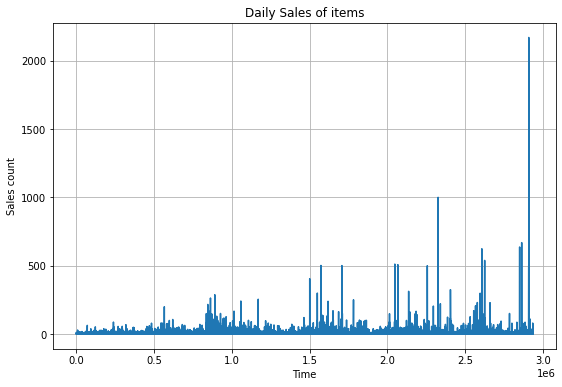

In [20]:
plt.figure(figsize = (9, 6))
plt.grid()
plt.plot(df_train['item_cnt_day'])
plt.title('Daily Sales of items')
plt.xlabel('Time')
plt.ylabel('Sales count')
plt.show()

In [21]:
df_train[['shop_id','item_id','item_price','item_cnt_day']].corr()

,shop_id,item_id,item_price,item_cnt_day
shop_id,1.000000,0.029396,-0.024034,-0.005329
item_id,0.029396,1.000000,-0.134104,0.016290
item_price,-0.024034,-0.134104,1.000000,0.011841
item_cnt_day,-0.005329,0.016290,0.011841,1.000000


### **Time Series Analysis**

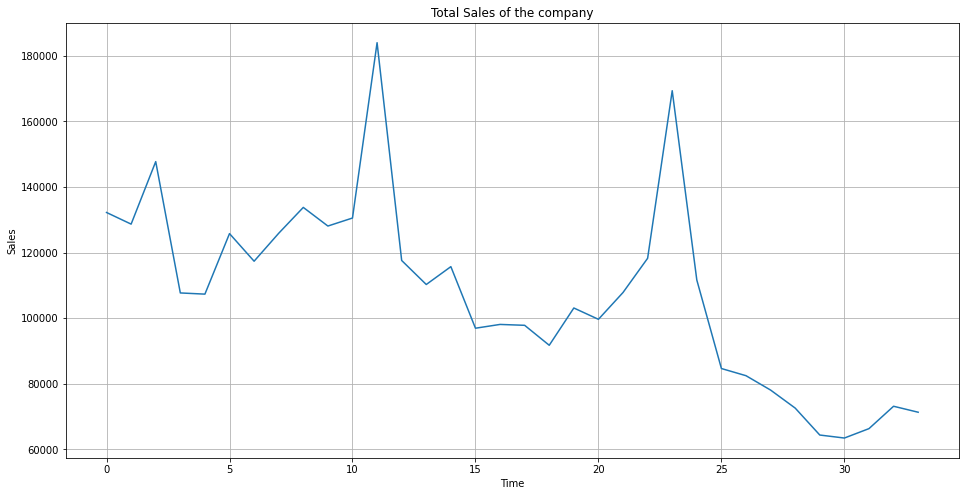

In [22]:
ts=df_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')

plt.figure(figsize=(16,8))
plt.grid()
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

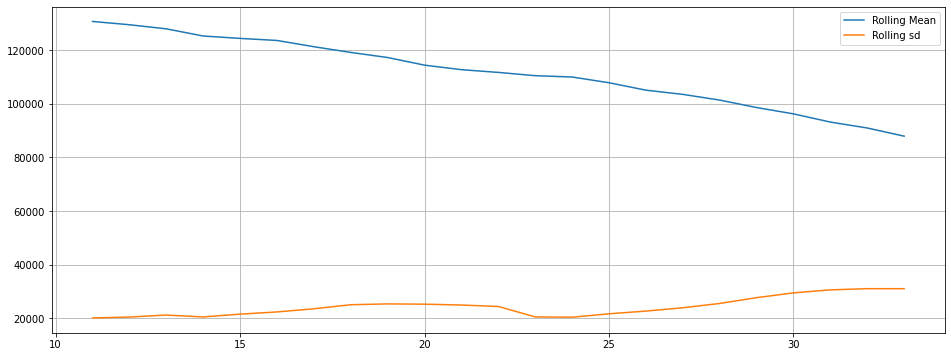

In [23]:
plt.figure(figsize=(16,6))
plt.grid()
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [24]:
data =df_train.groupby(["month"]).agg({'item_cnt_day':"sum"})
data
data.shape

(34, 1)

In [25]:
data["month"] =data.index
data

,item_cnt_day,month
month,,
2013-01-01,132221.0,2013-01-01
2013-02-01,128674.0,2013-02-01
2013-03-01,147734.0,2013-03-01
2013-04-01,107688.0,2013-04-01
2013-05-01,107326.0,2013-05-01
2013-06-01,125785.0,2013-06-01
2013-07-01,117364.0,2013-07-01
2013-08-01,125881.0,2013-08-01
2013-09-01,133770.0,2013-09-01


In [26]:
data.drop(["month"], axis =1, inplace=True)
data

,item_cnt_day
month,
2013-01-01,132221.0
2013-02-01,128674.0
2013-03-01,147734.0
2013-04-01,107688.0
2013-05-01,107326.0
2013-06-01,125785.0
2013-07-01,117364.0
2013-08-01,125881.0
2013-09-01,133770.0


In [27]:
data["item_cnt_mnt"] = data["item_cnt_day"]
data.head()

,item_cnt_day,item_cnt_mnt
month,,
2013-01-01,132221.0,132221.0
2013-02-01,128674.0,128674.0
2013-03-01,147734.0,147734.0
2013-04-01,107688.0,107688.0
2013-05-01,107326.0,107326.0


In [28]:
data.drop(["item_cnt_day"], axis =1, inplace=True)

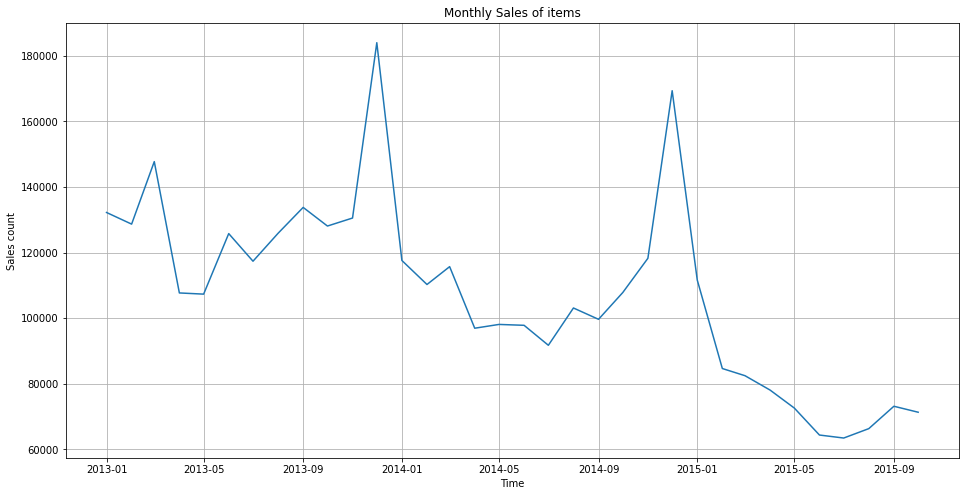

In [29]:
plt.figure(figsize = (16,8))
plt.grid()
plt.plot(data['item_cnt_mnt'])
plt.title('Monthly Sales of items')
plt.xlabel('Time')
plt.ylabel('Sales count')
plt.show()

Autocorrelation = 0.6653


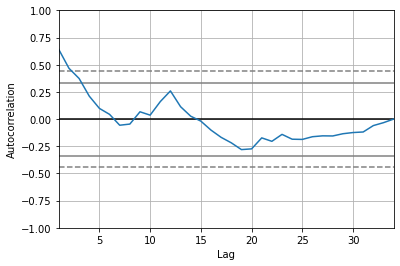

In [30]:
pd.plotting.autocorrelation_plot(data['item_cnt_mnt'])
print('Autocorrelation =', round(data['item_cnt_mnt'].autocorr(), 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


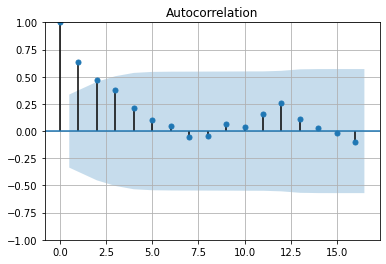

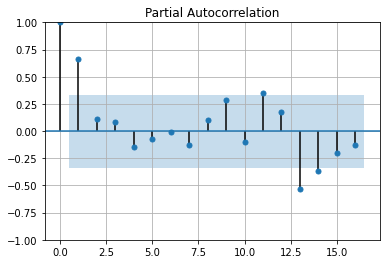

In [31]:
plot_acf(data['item_cnt_mnt'])
plt.grid()
plot_pacf(data['item_cnt_mnt'])
plt.grid()
plt.show()

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

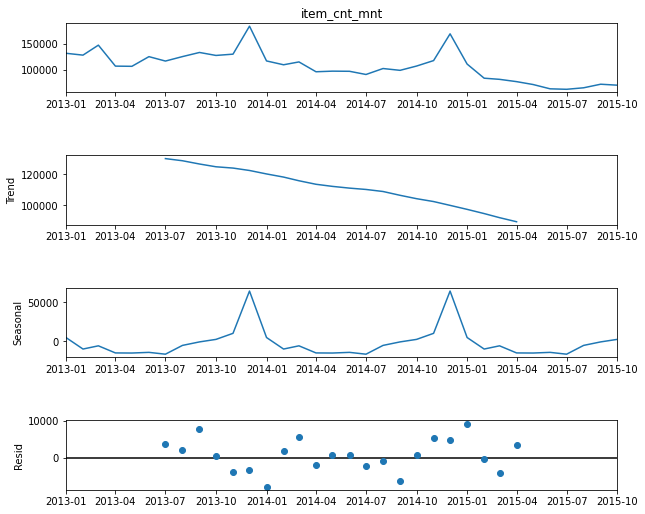

In [33]:
#Additive model
seasonal_decompose(data['item_cnt_mnt'], model = 'additive').plot().set_size_inches(10, 8) #default

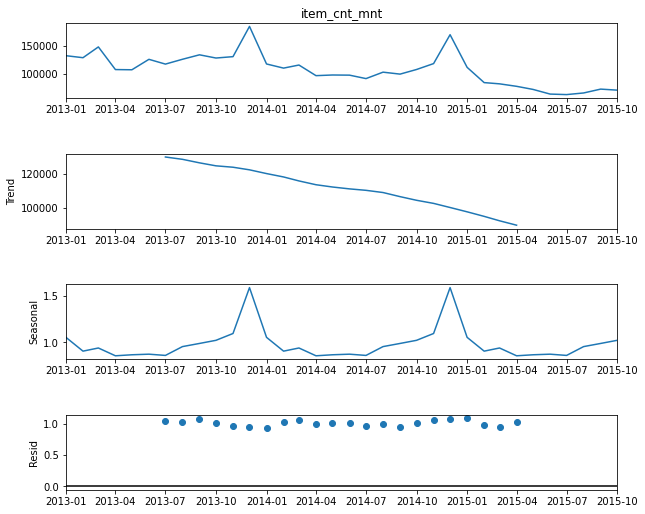

In [34]:
#Additive model
seasonal_decompose(data['item_cnt_mnt'], model = 'multiplicative').plot().set_size_inches(10, 8)

In [35]:
#Stationarity test: Two tests for checking the stationarity of a time series are used, namely the ADF test and the KPSS test.
def adfTester(timeseries):
    adfTest = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adfTest[0:4], index = ['ADF Statistic', 'p-value', 'Lags', 'Number of Observations'])
    for key, value in adfTest[4].items():
        output["Critical Value (%s)" %key] = value
    
    return print(output)

In [36]:
adfTester(data['item_cnt_mnt'])

ADF Statistic             -2.389088
p-value                    0.144840
Lags                       0.000000
Number of Observations    33.000000
Critical Value (1%)       -3.646135
Critical Value (5%)       -2.954127
Critical Value (10%)      -2.615968
dtype: float64


p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series.

In [37]:
#Grid search for parameters
def order_parameters(training_data):
    
    search_params = auto_arima(training_data, start_p = 0, start_q = 0, m = 12, seasonal = True, test = "adf", d = None, trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, 
                    stepwise = True)
 
    print("AIC = ", round(search_params.aic(), 2))
                  
    return search_params

In [38]:
model = order_parameters(data['item_cnt_mnt'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=448.661, Time=0.23 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=451.652, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=449.312, Time=0.11 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=437.962, Time=0.18 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=439.251, Time=0.28 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=438.039, Time=0.19 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=440.563, Time=0.64 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=448.513, Time=0.07 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=451.326, Time=0.15 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=448.997, Time=0.19 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=inf, T

In [39]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -215.981
Date:                            Wed, 07 Sep 2022   AIC                            437.962
Time:                                    11:56:02   BIC                            440.949
Sample:                                01-01-2013   HQIC                           438.545
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9860      0.300     -3.292      0.001      -1.573      -0.399
ma.S.L12      -0.0852      0.166   

In [40]:
prediction, confint = model.predict(n_periods = 6, return_conf_int = True) #95% CI default
df_confint = pd.DataFrame(confint)
print(confint.round(2))
print(prediction.round(2))

[[ 49873.15 106386.38]
 [ 85483.1  166769.31]
 [ 15483.35 116688.65]
 [-21491.67  97252.28]
 [-33913.44 100925.4 ]
 [-50135.8   99823.89]]
2015-11-01     78129.76
2015-12-01    126126.20
2016-01-01     66086.00
2016-02-01     37880.31
2016-03-01     33505.98
2016-04-01     24844.04
Freq: MS, dtype: float64


In [41]:
period_index = pd.period_range(start = data.index[-1], periods = 6, freq='M')

df_predict = pd.DataFrame({'Predicted item_cnt_mnt': prediction.round(2)}, index = period_index)
#df_predict['month'] = df_predict.index
print(df_predict)

         Predicted item_cnt_mnt
2015-10                     NaN
2015-11                     NaN
2015-12                     NaN
2016-01                     NaN
2016-02                     NaN
2016-03                     NaN


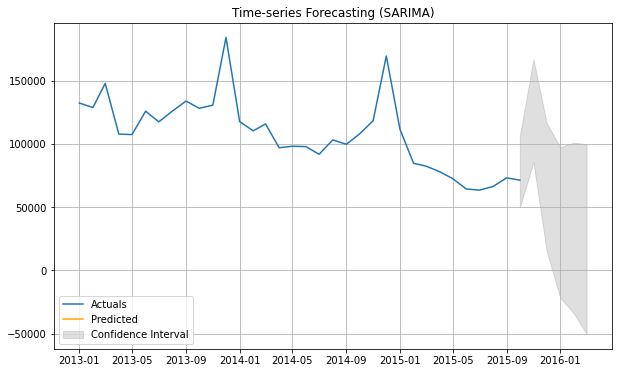

In [42]:
plt.figure(figsize = (10, 6))
plt.plot(data['item_cnt_mnt'], label = 'Actuals')
plt.plot(df_predict.to_timestamp(), color = 'orange', label = 'Predicted')
plt.fill_between(period_index.to_timestamp(), df_confint[0], df_confint[1], color = 'grey', alpha = 0.25, label = 'Confidence Interval')
plt.legend(loc = 'lower left')
plt.title('Time-series Forecasting (SARIMA)')
plt.grid()
plt.show()

In [43]:
train_df_tuple = df_train.groupby(['shop_id', 'item_id'])['date', 'item_cnt_day'].agg({'item_cnt_day':'sum'})
train_df_tuple = train_df_tuple.reset_index()
print(train_df_tuple)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


        shop_id  item_id  item_cnt_day
0             0       30          31.0
1             0       31          11.0
2             0       32          16.0
3             0       33           6.0
4             0       35          15.0
...         ...      ...           ...
424119       59    22154           1.0
424120       59    22155           1.0
424121       59    22162          16.0
424122       59    22164           6.0
424123       59    22167           4.0

[424124 rows x 3 columns]


In [44]:
df_test['item_cnt_month'] = (prediction[0].round(2)*len(df_test)/len(train_df_tuple))/len(df_test)
#df_test['item_cnt_month'] = prediction[0]*len(df_test)/len(train_df_tuple)
submission  = df_test.drop(['shop_id', 'item_id'], axis = 1)
print(submission)

            ID  item_cnt_month
0            0        0.184214
1            1        0.184214
2            2        0.184214
3            3        0.184214
4            4        0.184214
...        ...             ...
214195  214195        0.184214
214196  214196        0.184214
214197  214197        0.184214
214198  214198        0.184214
214199  214199        0.184214

[214200 rows x 2 columns]


In [45]:
submission.to_csv('submission.csv', index = False)